In [1]:
# Set environment variable for OPENAI_API_KEY in jupyter server
from fc_metric import calculate_fc_using_gpt
import pandas as pd
import matplotlib.pyplot as plt

## You only need the first part of this notebook to run the LM FC metric on the dataset
If you need to analyze an existing ranking, you can skip to second part of the notebook. 

The data can be downloaded from [here](https://github.com/Yale-LILY/SummEval?tab=readme-ov-file#human-annotations)  
Rename it to fit the naming (summ_eval_model_annotations.aligned.jsonl) and place it to the data folder.

In [3]:
df = pd.read_json('../data/summ_eval_model_annotations.aligned.jsonl', lines=True)

In [4]:
df.head()


,id,decoded,expert_annotations,turker_annotations,references,model_id,filepath
0,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson was brought on with only seven min...,"[{'coherence': 2, 'consistency': 1, 'fluency':...","[{'coherence': 3, 'consistency': 3, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M11,cnndm/dailymail/stories/8764fb95bfad8ee8492748...
1,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 3, 'consistency': 5, 'fluency':...","[{'coherence': 2, 'consistency': 3, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M13,cnndm/dailymail/stories/8764fb95bfad8ee8492748...
2,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 2, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 5, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M1,cnndm/dailymail/stories/8764fb95bfad8ee8492748...
3,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 2, 'consistency': 5, 'fluency':...","[{'coherence': 5, 'consistency': 5, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M14,cnndm/dailymail/stories/8764fb95bfad8ee8492748...
4,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 4, 'consistency': 5, 'fluency':...","[{'coherence': 2, 'consistency': 4, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M15,cnndm/dailymail/stories/8764fb95bfad8ee8492748...


Low: paul merson was brought on with only seven minutes remaining in his team 's 0-0 draw with burnley . andros townsend scored the tottenham midfielder in the 89th minute . paul merson had another dig at andros townsend after his appearance . the midfielder had been brought on to the england squad last week . click here for all the latest arsenal news news .  
High: paul merson has restarted his row with andros townsend . the tottenham midfielder was brought on with only seven minutes remaining in his team 's 0-0 draw with burnley . andros townsend scores england 's equaliser in their 1-1 friendly draw with italy in turin .  
High: paul merson has restarted his row with andros townsend after the tottenham midfielder was brought on with only seven minutes remaining in his team 's 0-0 draw with burnley on sunday . merson initially angered townsend for writing in his sky sports column that ` if andros townsend can get in -lrb- the england team -rrb- then it opens it up to anybody ' townsend was brought on in the 83rd minute for tottenham as they drew 0-0 against burnley .


In [25]:
df["average_consistency_evaluation_expert"] = df["expert_annotations"].apply(lambda x: round(sum([ measure["consistency"]for measure in x ])/len(x)))
df["median_consistency_evaluation_expert"] = df["expert_annotations"].apply(lambda x: round(sorted([ measure["consistency"]for measure in x ])[len(x)//2]))

In [26]:
df["average_consistency_evaluation_expert"].describe()

count    1600.000000
mean        4.675625
std         0.914291
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: average_consistency_evaluation_expert, dtype: float64

In [5]:
focus = df.iloc[0:64].copy()


In [6]:
calculate_fc_using_gpt("this is a summary. 12.", "THis is the summary of the summary. It contains the number 12.", fail_silent=False)

3

In [29]:
focus["lm_fc_rating"] = focus.apply(lambda x: calculate_fc_using_gpt("; ".join(x["references"]), x["decoded"], fail_silent=False), axis = 1)
timestamp = pd.Timestamp.now()
focus.to_csv(f"../data/temp_fc_ratings_{timestamp}.csv")

## Use the following code to load previous results and analyze them

In [4]:
#timestamp = 24
focus = pd.read_csv(f"../data/temp_fc_ratings_{timestamp}.csv")

In [5]:
focus["lm_fc_rating"].describe()

count    64.000000
mean      3.593750
std       0.811011
min       1.000000
25%       3.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: lm_fc_rating, dtype: float64

In [6]:
focus["average_consistency_evaluation_expert"].describe()


count    64.000000
mean      4.718750
std       0.844567
min       1.000000
25%       5.000000
50%       5.000000
75%       5.000000
max       5.000000
Name: average_consistency_evaluation_expert, dtype: float64

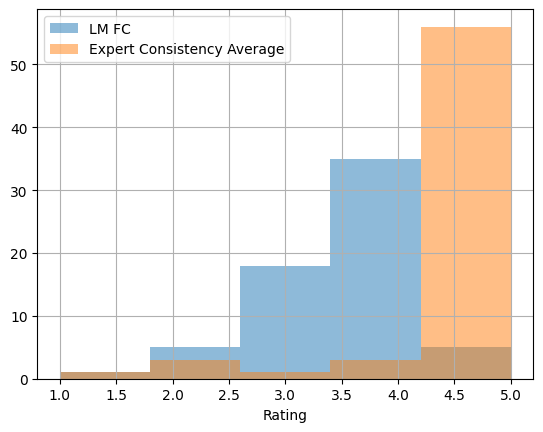

In [7]:
ax1 = focus["lm_fc_rating"].hist(
    alpha=0.5,
    bins=5,
    label="LM FC"
)
ax2 = focus["average_consistency_evaluation_expert"].hist(
    alpha=0.5,
    bins=5, 
    label="Expert Consistency Average"
)
plt.xlabel("Rating")
plt.legend()
plt.show()

In [8]:
# correlation analysis
focus["lm_fc_rating"].corr(focus["average_consistency_evaluation_expert"]), focus["lm_fc_rating"].corr(focus["average_consistency_evaluation_expert"], method="spearman", ) 

(np.float64(0.456235782995921), np.float64(0.39040568490631783))

In [9]:
# rank correlation with ties using scipy spearman
from scipy.stats import spearmanr, rankdata
import numpy as np

focus["lm_fc_rating_rank"] = rankdata(np.round(focus["lm_fc_rating"]) )
spearmanr(focus["lm_fc_rating_rank"], focus["average_consistency_evaluation_expert"])


SignificanceResult(statistic=np.float64(0.39040568490631783), pvalue=np.float64(0.0014262926428106457))

In [12]:
# calculating the percentage of correct rankings 4 or higher
focus["lm_good"] = focus["lm_fc_rating"] >= 4
focus["expert_good"] = focus["average_consistency_evaluation_expert"] >= 4
true_positive = (focus["lm_good"] & focus["expert_good"]).sum() / len(focus)
true_negative = (~focus["lm_good"] & ~focus["expert_good"]).sum() / len(focus)
false_positive = (focus["lm_good"] & ~focus["expert_good"]).sum() / len(focus)
false_negative = (~focus["lm_good"] & focus["expert_good"]).sum() / len(focus)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall


(np.float64(0.975), np.float64(0.6610169491525424))

Precision should be interpreted as the  percentage of rankings 4 or higher by the LM, that were also ranked high by experts.  
Recall should be interpreted as the percentage of the good rankings by experts, that the LM also ranked high.

mean abs error: 1.21875


count    64.000000
mean      1.218750
std       0.723061
min       0.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       3.000000
Name: abs_error, dtype: float64

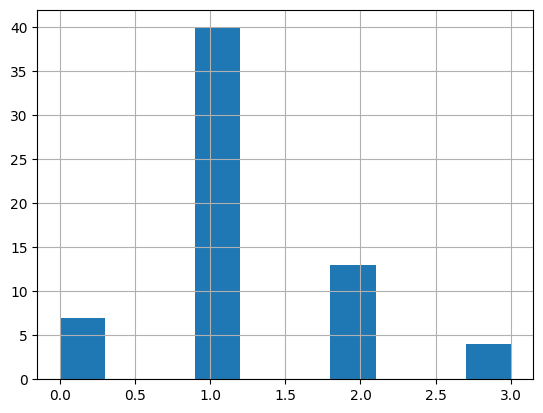

In [14]:
# average distance between predictions
focus["abs_error"] = abs(focus["lm_fc_rating"] - focus["average_consistency_evaluation_expert"]) 
print("mean abs error:", focus["abs_error"].mean())
focus["abs_error"].hist()
focus["abs_error"].describe()